# Regression Dilution and Correlated Errors
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/lin_regression_with_errors.ipynb)

Dealing with regression dilution and correlated errors in x and y.

This notebook was inspired by a presentation given by Prof. Angie Pendergrass on Dec. 8, 2022 at CSU. Once the accompanying paper (Kao and Pendergrass, in prep) is submitted I will link to the paper here. Also, that work is supported by the original work of [York (1969)](https://www.sciencedirect.com/science/article/abs/pii/S0012821X68800597?via%3Dihub) and [Mahon (1996)](https://doi.org/10.1080/00206819709465336) as well as others.

In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print("IN_COLAB = " + str(IN_COLAB))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

# -------------------------------------------------------
# set figure defaults
mpl.rcParams["figure.dpi"] = 175
LW = 2.25
SEED = 55  # define the random seed

IN_COLAB = False


### York Regression

In [ ]:
# Define the YorkReg class for York regression
# This code was adapted from https://faculty.epss.ucla.edu/~eyoung/Data/york_regression_edy.py

from scipy.stats import chi2


class YorkReg:
    def __init__(self, X, y, sigX, sigy, rho):
        self.X = X
        self.y = y
        self.sigX = sigX
        self.sigy = sigy
        self.rho = rho
        self.fit_slope = None
        self.fit_intercept = None
        self.sig_slope = None
        self.sig_intercept = None
        self.chi_2 = None
        self.rchi_2 = None
        self.q = None
        self.sXoss = None
        self.syoss = None
        self.calculate()

    def calculate(self):
        b = -1
        for iter in range(500):
            b0 = b
            # Weights...
            wt = 1 / (
                self.sigy**2
                + (b**2) * (self.sigX**2)
                - 2 * self.rho * self.sigX * self.sigy
            )
            # Centroid (weighted mean)
            self.sXoss = np.sum(self.X * wt) / np.sum(wt)
            self.syoss = np.sum(self.y * wt) / np.sum(wt)

            # Calculate intercept a and slope b.
            t1 = (self.X - self.sXoss) * (self.sigy**2)
            t2 = (self.y - self.syoss) * (self.sigX**2) * b
            t3 = self.sigX * self.sigy * self.rho
            st2 = np.sum(
                (wt**2) * (self.y - self.syoss) * (t1 + t2 - t3 * (self.y - self.syoss))
            )
            st3 = np.sum(
                (wt**2)
                * (self.X - self.sXoss)
                * (t1 + t2 - b * t3 * (self.X - self.sXoss))
            )
            b = st2 / st3
            if abs(b - b0) < 10 ** (-8):
                break

        # Best fit slope and intercept
        self.fit_slope = b
        self.fit_intercept = self.syoss - self.sXoss * self.fit_slope

        # Calculate errors in intercept and slope
        self.sig_slope = np.sqrt(1 / np.sum(wt * (self.X - self.sXoss) ** 2))
        self.sig_intercept = self.sig_slope * np.sqrt(
            np.sum(wt * self.X**2 / np.sum(wt))
        )

        # Calculate chi squared statistic
        self.chi_2 = np.sum(
            wt * (self.y - self.fit_intercept - self.fit_slope * self.X) ** 2
        )
        df = len(self.y) - 2
        # Compute reduced chi squared
        self.rchi_2 = self.chi_2 / df

        # Compute "goodness of fit"
        # q is the probability that chi^2 should exceed the statistic X^2
        self.q = 1 - chi2.cdf(self.rchi_2, df)

    def get_results(self):
        return (
            self.fit_slope,
            self.fit_intercept,
            self.sig_slope,
            self.sig_intercept,
            self.chi_2,
            self.rchi_2,
            self.q,
            self.sXoss,
            self.syoss,
        )

# Regression Dilution

First, let's make two data sets x and y that both have errors, but these errors are uncorrelated. Below we show that standard ordinary least squares regression does a very poor job estimating the slope in this case as it assumes that only y has errors (i.e. it assumes that x does not have errors). We can then use York regression to fit again (but we can use the fact that we know the errors in x and y are uncorrelated).

slope_true = 1.0
est. slope_xynoise = 0.65
est. york_slope = 0.9433548750540454


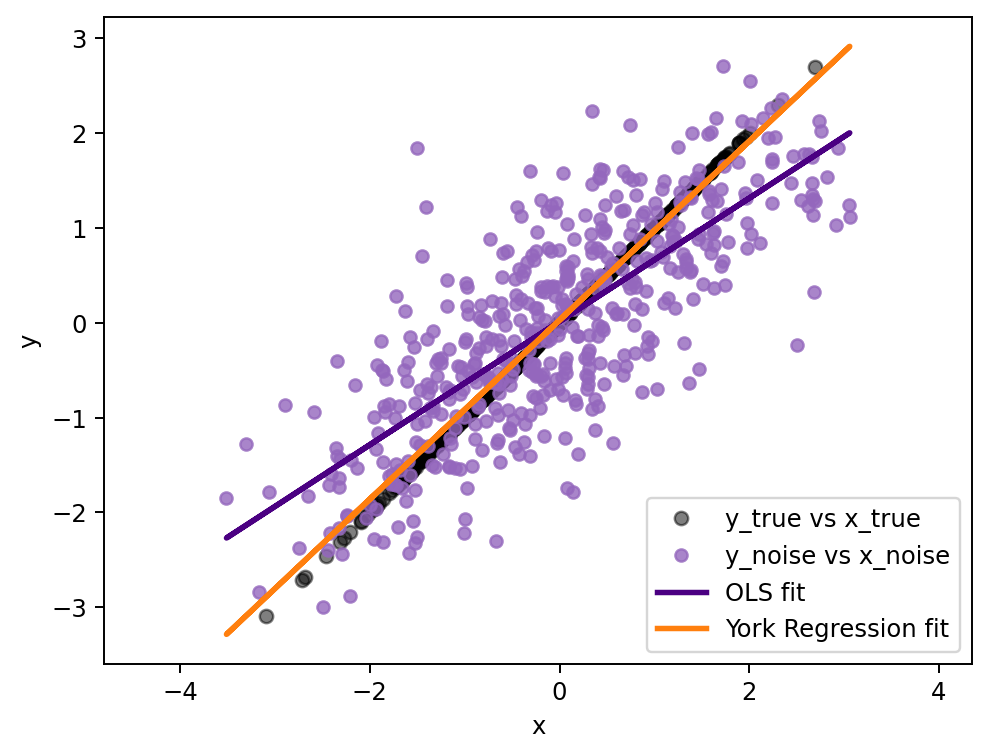

In [ ]:
# ---------------------------------------------------------------------------
rng = np.random.default_rng(SEED + 2)  # set random seed to get reproducible results
N = 500  # number of samples
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1.0  # spread of the noise-less x-values
# ---------------------------------------------------------------------------

# CREATE X DATA
x = std_X * np.random.normal(size=N)
x_noise = sigma_x * rng.normal(size=len(x))
x_obs = x + x_noise

# CREATE Y DATA BASED ON X but with UNCORRELATED ERRORS
y = slope_true * x
y_noise = sigma_y * rng.normal(size=len(x))
y_obs = y + y_noise

# FIT REGRESSION LINE
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs, y_obs)
slope_xynoise = slope_xynoise.round(2)

# FIT YORK REGRESSION LINE
york_fit = YorkReg(
    x_obs, y_obs, sigma_x * np.ones(x_noise.shape), sigma_y * np.ones(y.shape), rho=0.0
)
york_slope = york_fit.fit_slope
york_intercept = york_fit.fit_intercept

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")

plt.figure()
plt.plot(x, y, ".", color="k", markersize=11, label=f"y_true vs x_true", alpha=0.5)
plt.plot(
    x_obs,
    y_obs,
    ".",
    color="tab:purple",
    markersize=10,
    label=f"y_noise vs x_noise",
    alpha=0.8,
)
plt.plot(
    x_obs,
    slope_xynoise * x_obs + intercept_noise,
    "-",
    color="indigo",
    linewidth=LW,
    label="OLS fit",
)
plt.plot(
    x_obs,
    x_obs * york_slope + york_intercept,
    "-",
    color="tab:orange",
    linewidth=LW,
    label="York Regression fit",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis("equal")
plt.show()

Now let's repeat this 10,000 times for lots of different data and best-fit lines. As we discussed in class, we can compute the theoretical average error that regression dilution will cause. Let's see if it works.

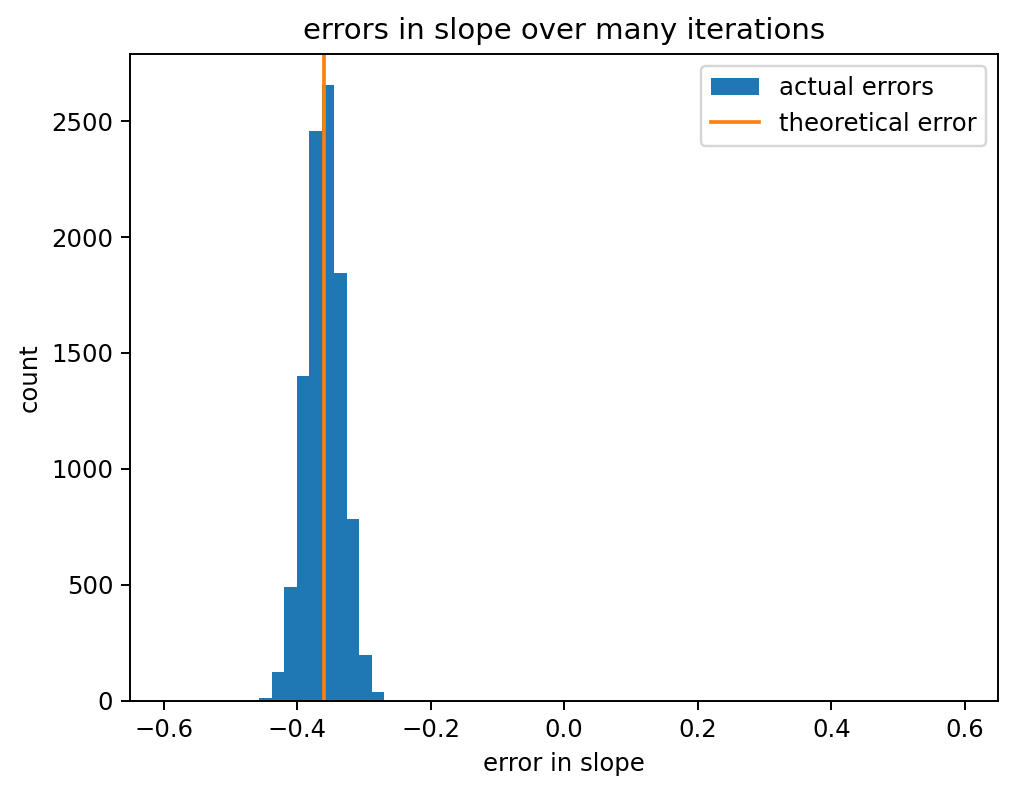

theoretical error = -0.36
average error     = -0.3599526885884073


In [ ]:
rng = np.random.default_rng(SEED + 2)  # set random seed to get reproducible results
niters = 10_000

slope_vec = np.zeros((niters,))
for i in np.arange(0, niters):

    # CREATE TRUTH X DATA
    x = std_X * np.random.normal(size=N)

    # ONLY Y HAS NOISE
    y = slope_true * x
    y_noise = sigma_y * rng.normal(size=len(x))
    y_obs = y + y_noise

    # X AND Y BOTH HAVE UNCORRELATED NOISE
    x_noise = sigma_x * rng.normal(size=len(x))
    x_obs = x + x_noise
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs, y_obs)
    slope_vec[i] = slope_xynoise - slope_true

theory_error = slope_true * ((std_X**2) / (std_X**2 + sigma_x**2) - 1)

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title("errors in slope over many iterations")
plt.legend()
plt.xlim(-0.65, 0.65)
plt.xlabel("error in slope")
plt.ylabel("count")
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

Wow! It definitely works. That is awesome.

# Correlated errors in x and y

Now, let's repeat the process but all the errors in x and the errors in y to be correlated with one another.

slope_true = 1.0
est. slope_xynoise = 0.49
est. york_slope = 1.026576506419649
est. slope_odr = 1.206479783553713


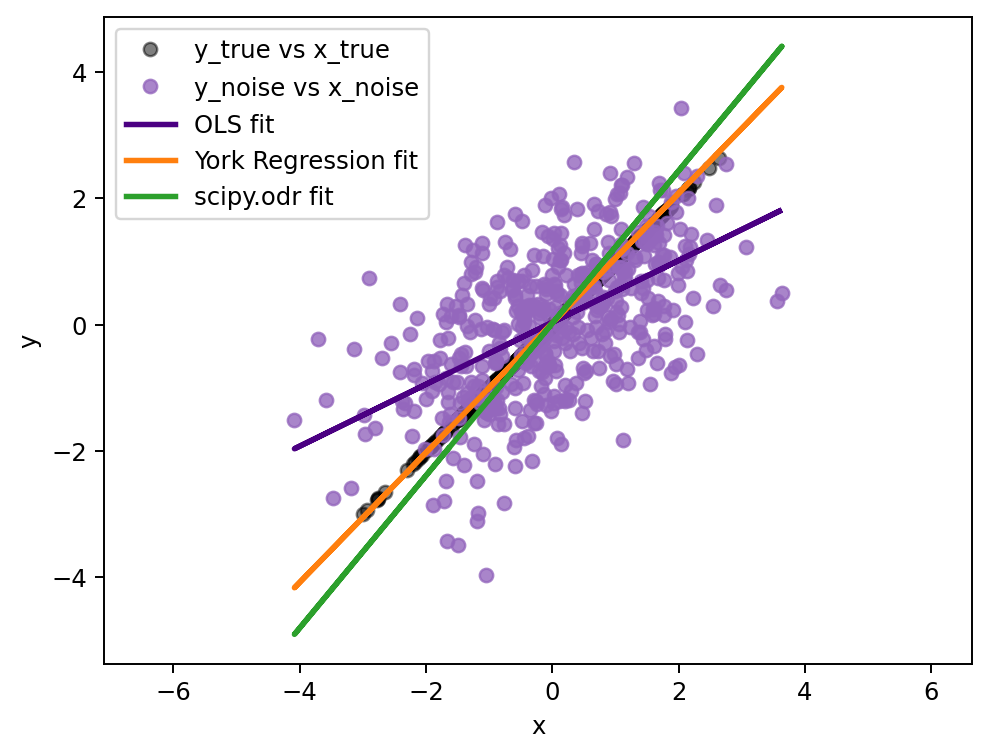

In [ ]:
# ---------------------------------------------------------------------------
rng = np.random.default_rng(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
r_xy = -0.75  # correlation of x and y errors
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1.0  # spread of the noise-less x-values
# ---------------------------------------------------------------------------

# DEFINE THE CORRELATED ERRORS
mean = [0, 0]
cov = [[sigma_x**2, r_xy * sigma_x * sigma_y], [r_xy * sigma_x * sigma_y, sigma_y**2]]
x_noise, y_noise = rng.multivariate_normal(mean, cov, N).T

# CREATE TRUTH X DATA AND ADD ERRORS
x = std_X * np.random.normal(size=N)
x_obs = x + x_noise

# CREATE Y DATA BASED ON X but with CORRELATED ERRORS
y = slope_true * x
y_obs = y + y_noise

# PERFORM OLS REGRESSION WHEN X AND Y BOTH HAVE ERRORS THAT ARE CORRELATED
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs, y_obs)
slope_xynoise = slope_xynoise.round(2)

# FIT YORK REGRESSION LINE
york_fit = YorkReg(
    x_obs, y_obs, sigma_x * np.ones(x_obs.shape), sigma_y * np.ones(y.shape), rho=r_xy
)
york_slope = york_fit.fit_slope
york_intercept = york_fit.fit_intercept

# SCIPY ODR FIT
# assumes that the errors in x and y are uncorrelated
import scipy.odr as odr


def f(B, x):
    return B[0] * x + B[1]


model = odr.Model(f)
data = odr.RealData(x_obs, y_obs, sx=sigma_x, sy=sigma_y)
odr_fit = odr.ODR(data, model, beta0=[1.0, 0.0])
odr_output = odr_fit.run()
slope_odr = odr_output.beta[0]

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")
print(f"est. {slope_odr = }")

plt.figure()
plt.plot(x, y, ".", color="k", markersize=11, label=f"y_true vs x_true", alpha=0.5)
plt.plot(
    x_obs,
    y_obs,
    ".",
    color="tab:purple",
    markersize=11,
    label=f"y_noise vs x_noise",
    alpha=0.8,
)
plt.plot(
    x_obs,
    x_obs * slope_xynoise + intercept_noise,
    "-",
    color="indigo",
    linewidth=LW,
    label="OLS fit",
)
plt.plot(
    x_obs,
    x_obs * york_slope + york_intercept,
    "-",
    color="tab:orange",
    linewidth=LW,
    label="York Regression fit",
)
plt.plot(
    x_obs,
    x_obs * slope_odr + odr_output.beta[1],
    "-",
    color="tab:green",
    linewidth=LW,
    label="scipy.odr fit",
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis("equal")
plt.show()

When the errors in x and y are correlated, York regression is essential for getting a good estimate of the slope. Unfortunately, this means you need to have an estimate of this correlation of the errors.

As above, let's check to see if our OLS-estimated slope has an error given by the equation in the notes.

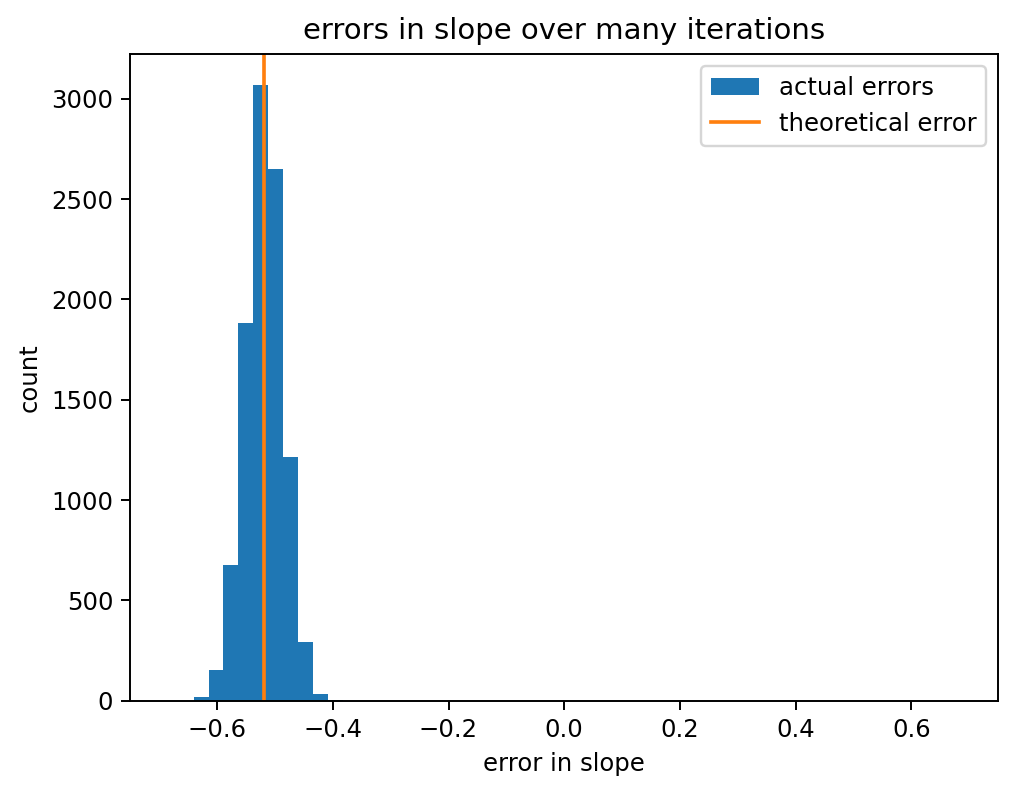

theoretical error = -0.5184
average error     = -0.5181461625970324


In [ ]:
rng = np.random.default_rng(SEED)  # set random seed to get reproducible results
niters = 10_000

slope_vec = np.zeros((niters,))
york_vec = np.zeros((niters,))
for i in np.arange(0, niters):

    # DEFINE THE CORRELATED ERRORS
    mean = [0, 0]
    cov = [
        [sigma_x**2, r_xy * sigma_x * sigma_y],
        [r_xy * sigma_x * sigma_y, sigma_y**2],
    ]
    x_noise, y_noise = rng.multivariate_normal(mean, cov, N).T

    # CREATE TRUTH X DATA AND ADD ERRORS
    x = std_X * np.random.normal(size=N)
    x_obs = x + x_noise

    # CREATE Y DATA BASED ON X but with CORRELATED ERRORS
    y = slope_true * x
    y_obs = y + y_noise

    # PERFORM OLS REGRESSION WHEN X AND Y BOTH HAVE ERRORS THAT ARE CORRELATED
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs, y_obs)
    slope_vec[i] = slope_xynoise - slope_true

incorrect_slope = (r_xy * sigma_x * sigma_y) / (
    std_X**2 + sigma_x**2
) + slope_true * (std_X**2) / (std_X**2 + sigma_x**2)
theory_error = incorrect_slope - slope_true

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title("errors in slope over many iterations")
plt.xlabel("error in slope")
plt.ylabel("count")
plt.legend()
plt.xlim(-0.75, 0.75)
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

It works again!